In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import random
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import random
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.uint8)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame.numpy()


def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=1):
    """
    Extracts frames sequentially from the start of the video file, with a specified step between frames.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image (height, width).
      frame_step: Number of frames to skip between extracted frames.

    Returns:
      A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    result = []
    src = cv2.VideoCapture(str(video_path))

    src.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Start from the first frame

    # Attempt to read the first frame
    ret, frame = src.read()
    if ret:
        frame = format_frames(frame, output_size)
        result.append(frame)
    else:
        # If the first frame can't be read, append a zero frame and exit
        result.append(np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8))

    # Read subsequent frames with the specified frame_step
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            # Append a zero-like frame if no more frames can be read
            result.append(np.zeros_like(result[0]))

    src.release()

    # Convert the list of frames to a NumPy array and adjust color channels from BGR to RGB
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
batch_size = 16
num_frames = 30

# Define paths using pathlib
train_path = pathlib.Path('/content/drive/MyDrive/dataset/train/')
test_path = pathlib.Path('/content/drive/MyDrive/dataset/test/')
val_path = pathlib.Path('/content/drive/MyDrive/dataset/val/')

# Update output_signature to match the expected shapes:
# - The first element of the tuple describes the input tensor to the model:
#   This should be (num_frames, 224, 224, 3) for each video in the batch.
# - The second element describes the labels, which should be a scalar value per video (batch).
output_signature = (
    tf.TensorSpec(shape=(num_frames, 224, 224, 3), dtype=tf.uint8),  # Updated input shape per video
    tf.TensorSpec(shape=(), dtype=tf.uint8)  # Scalar integer for the label
)

# Generator for training data
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(train_path, num_frames, training=True),
    output_signature=output_signature
)
train_ds = train_ds.batch(batch_size)

# Generator for test data
test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(test_path, num_frames),
    output_signature=output_signature
)
test_ds = test_ds.batch(batch_size)

# Generator for validation data
val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(val_path, num_frames),
    output_signature=output_signature
)
val_ds = val_ds.batch(batch_size)


In [ ]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (16, 30, 224, 224, 3)
Label: (16,)


In [ ]:
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

In [ ]:
model_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=True, mode="max", save_freq="epoch")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 5*1e-12,
                                   )

callbacks = [model_save,  reduce_lr]

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
def build_model(learning_rate):
    """
    Builds a TensorFlow/Keras model with a specified learning rate.

    Args:
    learning_rate: The learning rate to use for the Adam optimizer.

    Returns:
    A compiled Keras model.
    """
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False

    model = models.Sequential([
        layers.TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
        layers.TimeDistributed(layers.GlobalAveragePooling2D()),
        layers.GRU(256, return_sequences=True),
        layers.GRU(128),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0 without the top layer to use as a feature extractor
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Set the base model as non-trainable
base_model.trainable = False

# Define the full model using a Sequential model
model = models.Sequential([
    # Apply EfficientNetB0 to each frame of the video
    layers.TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
    layers.TimeDistributed(layers.GlobalAveragePooling2D()),

    # Use GRU layers to capture temporal relationships
    layers.GRU(256, return_sequences=True),
    layers.GRU(128),

    # Dense layers for classification
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


In [ ]:
model.compile(optimizer = adam, loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history =  model.fit(train_ds, validation_data=val_ds, epochs = 20, callbacks = callbacks)

Epoch 1/20
164/164 [==============================] - 3981s 24s/step - loss: 1.9980 - accuracy: 0.2932 - val_loss: 1.7193 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 2/20
164/164 [==============================] - 56s 342ms/step - loss: 1.5585 - accuracy: 0.4484 - val_loss: 1.5284 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 3/20
164/164 [==============================] - 56s 343ms/step - loss: 1.2782 - accuracy: 0.5528 - val_loss: 1.3759 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 4/20
164/164 [==============================] - 56s 343ms/step - loss: 1.0220 - accuracy: 0.6453 - val_loss: 1.2052 - val_accuracy: 0.5963 - lr: 0.0010
Epoch 5/20
164/164 [==============================] - 56s 343ms/step - loss: 0.7867 - accuracy: 0.7324 - val_loss: 1.1241 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 6/20
164/164 [==============================] - 56s 342ms/step - loss: 0.6427 - accuracy: 0.7691 - val_loss: 1.4556 - val_accuracy: 0.5775 - lr: 0.0010
Epoch 7/20
164/164 [==============================] 

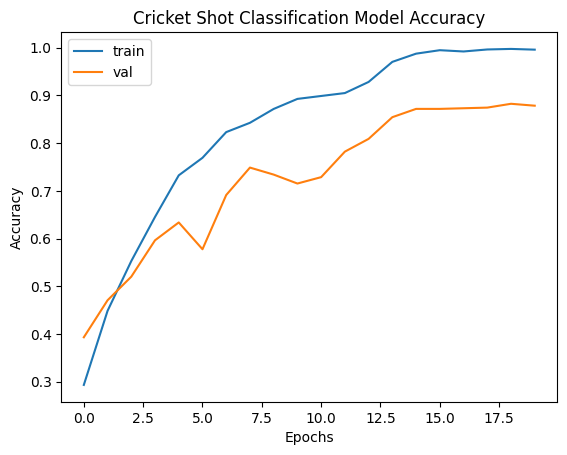

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cricket Shot Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('custom_1_acc.png', bbox_inches='tight')
plt.show()

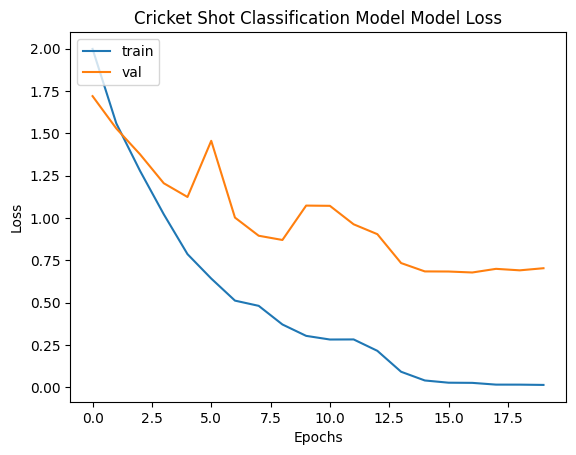

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cricket Shot Classification Model Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('custom_1_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

24/24 [==============================] - 593s 25s/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

In [ ]:
conf_mat

array([[37,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 34,  0,  1,  0,  0,  0,  1,  1],
       [ 1,  0,  0, 36,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 36,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  1, 37,  0,  1,  0,  0],
       [ 1,  1,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1, 35,  2,  0],
       [ 2,  0,  0,  0,  1,  1,  0,  0, 35,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  2, 37]])

In [ ]:
classes = {'cover': 0, 'defense': 1, 'flick': 2, 'hook': 3, 'late_cut': 4, 'lofted': 5, 'pull': 6, 'square_cut': 7, 'straight': 8, 'sweep': 9}

In [ ]:
from sklearn import metrics
report = metrics.classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

       cover       0.90      0.97      0.94        38
     defense       0.97      0.97      0.97        40
       flick       0.97      0.92      0.94        37
        hook       1.00      0.97      0.99        37
    late_cut       0.90      0.97      0.94        37
      lofted       0.93      0.93      0.93        40
        pull       0.94      0.92      0.93        37
  square_cut       0.95      0.90      0.92        39
    straight       0.88      0.90      0.89        39
       sweep       0.95      0.93      0.94        40

    accuracy                           0.94       384
   macro avg       0.94      0.94      0.94       384
weighted avg       0.94      0.94      0.94       384



In [ ]:
import numpy as np

def classify_video(video_path, model, frame_count, class_labels):
    # Process the video file to get the frames
    frames = frames_from_video_file(video_path, frame_count)

    # Add batch dimension if the model expects it
    frames = np.expand_dims(frames, axis=0)

    # Use the model to predict the class probabilities
    predictions = model.predict(frames)
    print("Raw predictions:", predictions)

    # Convert predictions to class labels
    predicted_class_idx = np.argmax(predictions, axis=1)[0]  # Get the index of the max class score
    print("Predicted class index:", predicted_class_idx)

    # Get the class name using the predicted index
    predicted_class_name = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_idx)]

    # Calculate the confidence percentage of the predicted class
    confidence = predictions[0][predicted_class_idx] * 100  # Assuming softmax output, multiply by 100 for percentage
    print("Confidence (%): {:.2f}%".format(confidence))

    return predicted_class_name, confidence


In [ ]:
# Example usage:
video_path = '/content/drive/MyDrive/dataset/test/cover/26.mp4'
predicted_class, confidence = classify_video(video_path, model, frame_count=30, class_labels=classes)
print(f"The predicted class for the video is: {predicted_class}", f"Confidence: {confidence:.2f}%")

1/1 [==============================] - 0s 46ms/step
Raw predictions: [[7.4831825e-01 3.9095983e-05 2.4264410e-01 2.5647134e-07 1.6662749e-05
  1.3422091e-03 2.6888697e-06 4.3071891e-06 7.6319682e-03 5.2202330e-07]]
Predicted class index: 0
Confidence (%): 74.83%
The predicted class for the video is: cover Confidence: 74.83%


In [ ]:
# Path to the saved weights
weights_path = '/content/models/Custom3_20_weights.h5'

# Load the weights into the model
model.load_weights(weights_path)
